In [1]:
#!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller  
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from pmdarima.arima import auto_arima
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.simplefilter(action="ignore")
import math


In [2]:
ticker = 'ZM'
df = pd.read_csv(f'data/{ticker}_stock_data.csv', index_col = 'Unnamed: 0')
df.index = pd.to_datetime(df.index)
series = df[['4. close']]

In [3]:
#Function to determine if data is stationary 

def test_stationarity(series, window=365):

    #get the rolling mean and rolling standard deviation
    rol_mean = series.rolling(window).mean()
    rol_std = series.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    closing = plt.plot(series, color='blue',label='Closing Price')
    mean = plt.plot(rol_mean, color='purple', label='Rolling Mean')
    std = plt.plot(rol_std, color='red', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Stock Price, Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Dickey-Fuller Test:')
    df = adfuller(series, autolag='AIC', maxlag = 20 )
    df_results = pd.Series(df[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in df[4].items():
        df_results['Critical Value (%s)'%key] = value
    pvalue = df[1]
    #https://thepythonguru.com/python-string-formatting/
    if pvalue < 0.05:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(df_results)

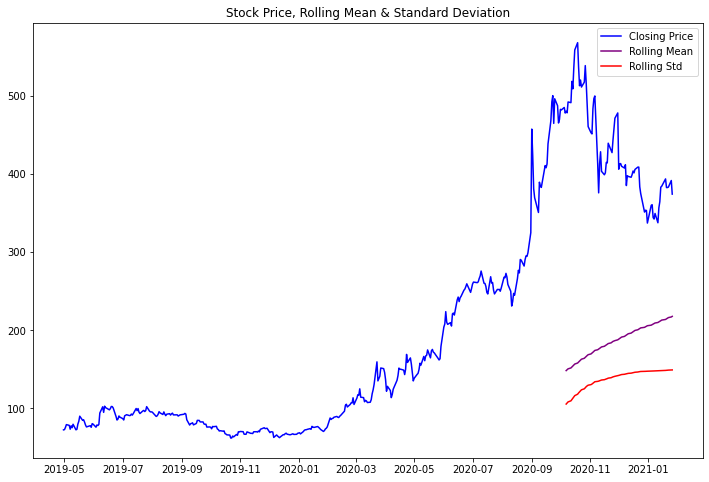

Dickey-Fuller Test:
p-value = 0.9178. The series is likely non-stationary.
Test Statistic                 -0.352
p-value                         0.918
Number of Lags Used             4.000
Number of Observations Used   435.000
Critical Value (1%)            -3.445
Critical Value (5%)            -2.868
Critical Value (10%)           -2.570
dtype: float64


In [4]:
test_stationarity(series)

In [5]:
series_diff = series.diff()
series_diff = series_diff.dropna()

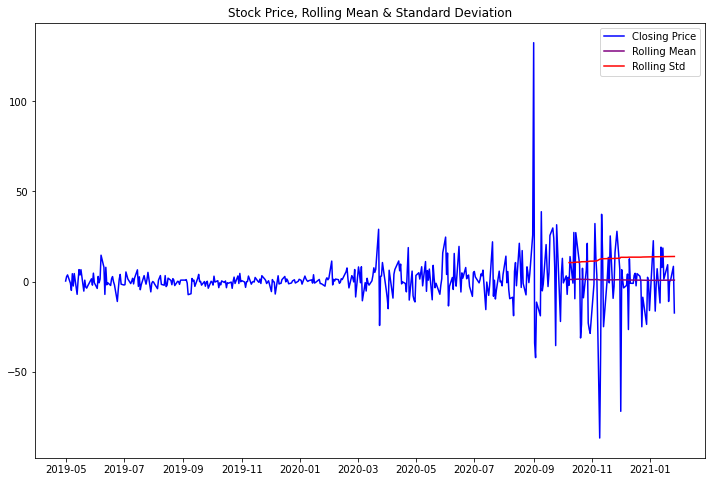

Dickey-Fuller Test:
p-value = 0.0329. The series is likely stationary.
Test Statistic                 -3.022
p-value                         0.033
Number of Lags Used            20.000
Number of Observations Used   418.000
Critical Value (1%)            -3.446
Critical Value (5%)            -2.868
Critical Value (10%)           -2.570
dtype: float64


In [6]:
test_stationarity(series_diff)

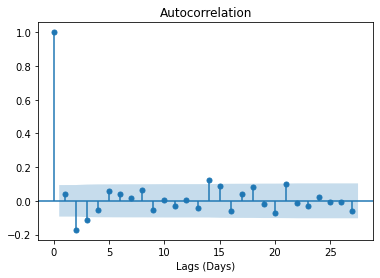

In [7]:
plot_acf(series_diff)
plt.xlabel('Lags (Days)')
plt.show()


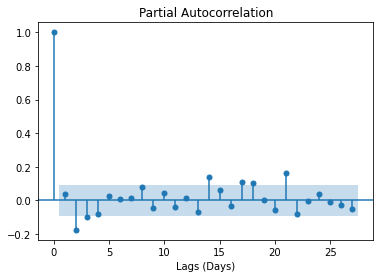

In [8]:
plot_pacf(series_diff)
plt.xlabel('Lags (Days)')
plt.show()

In [9]:
print(f'Number of observations: {len(series)}')
print(f'Number of training observations: {round(len(series) * 0.90)}')
print(f'Number of testing observations: {len(series) - round(len(series) * 0.90)}')

Number of observations: 440
Number of training observations: 396
Number of testing observations: 44


In [10]:
plot_axis = len(series)
plot_axis

440

In [11]:
split_index = round(len(series) * 0.90) +1
split_index

397

In [12]:
train = series.iloc[:split_index,]
test = series.iloc[split_index:,]

In [13]:
#Get EOY label for plot
index_ = [pd.to_datetime(date, format='%Y').date() 
        for date in pd.date_range(df.index[0], df.index[-1], freq="Y")]

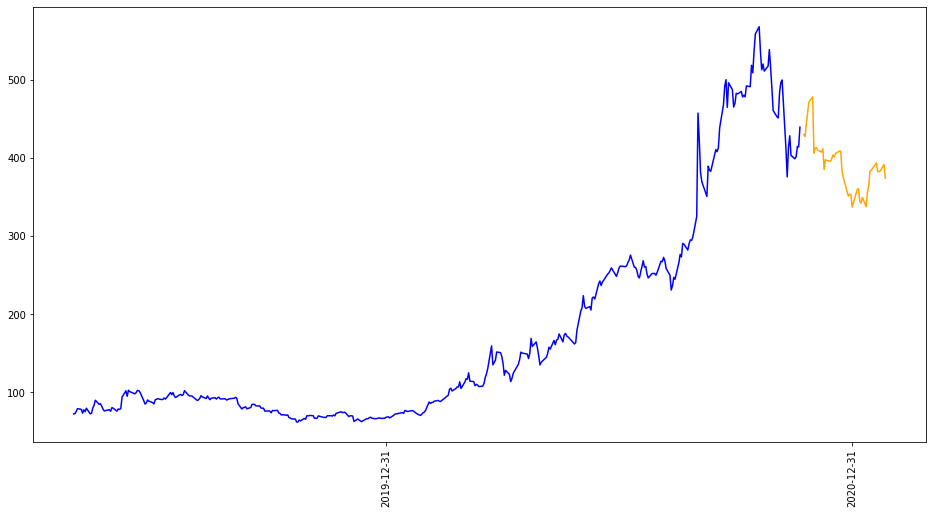

In [14]:
plt.figure(figsize=(16, 8))
plt.plot(train, c='blue')
plt.plot(test, c='orange')
plt.xticks(index_, rotation = 90);

In [15]:
#Run auto Arima model to determine best order

model_autoARIMA = auto_arima(train, start_p=0, start_q=0, 
                             test='adf',      #find d
                      max_p=3, max_q=3,       #set max for p and q
                      m=1,                    # freq for series
                      d=None,                 # model determine 'd'
                      seasonal=False,         
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3117.751, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3118.041, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3117.131, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3117.981, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3114.641, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3101.899, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3106.037, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3103.428, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3102.267, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3103.905, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3103.456, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3105.788, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3103.767, Time=0.05 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.444 seconds


In [16]:
model_autoARIMA.order

(2, 1, 1)

In [17]:
print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  397
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1545.949
Date:                Wed, 27 Jan 2021   AIC                           3101.899
Time:                        16:32:01   BIC                           3121.806
Sample:                             0   HQIC                          3109.785
                                - 397                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6273      0.389      1.614      0.106      -0.134       1.389
ar.L1          0.5364      0.119      4.497      0.000       0.303       0.770
ar.L2         -0.2272      0.037     -6.061      0.0

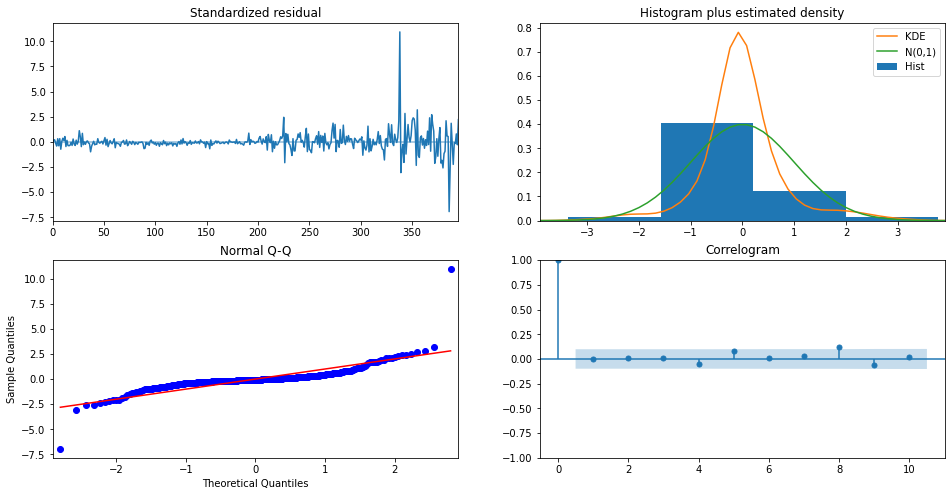

In [18]:
model_autoARIMA.plot_diagnostics(figsize = (16, 8))
plt.show()

Interpretting the residual plots from autoARIMA

- Standardized Residual - Massive increase in variance as we move right 
- Histogram shows that we have a normal distirbution 
- Distribution appears skewed at the ends
- ACF plot shows little pattern in residual errors

In [19]:
model = ARIMA(train, order = model_autoARIMA.order)
fitted = model.fit()
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.4. close   No. Observations:                  396
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1545.949
Method:                       css-mle   S.D. of innovations             11.999
Date:                Wed, 27 Jan 2021   AIC                           3101.899
Time:                        16:32:02   BIC                           3121.806
Sample:                             1   HQIC                          3109.785
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9082      0.453      2.004      0.045       0.020       1.796
ar.L1.D.4. close     0.5363      0.134      4.010      0.000       0.274       0.798
ar.L2.D.4. close    -0.2272 

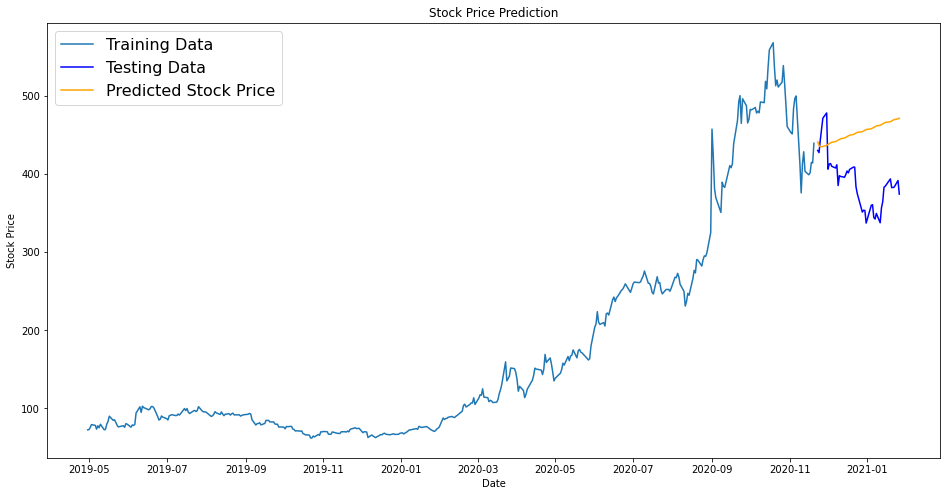

In [20]:
# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test.index)

plt.figure(figsize=(16,8))
plt.plot(train, label='Training Data')
plt.plot(test, color = 'blue', label='Testing Data')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(loc='best', fontsize=16)
plt.savefig('./images/ARIMA_GME.png', bbox_inches = 'tight')
plt.show()

In [21]:
#Models Maximum Prediction
fc_series.max()

471.6475663953004

In [22]:
#Models Minimum Prediction
fc_series.min()

434.93242127222663

In [23]:
# report performance
mse = mean_squared_error(test, fc)
print('MSE: '+ str(mse))
mae = mean_absolute_error(test, fc)
print('MAE: '+str (mae))
rmse = math.sqrt(mean_squared_error(test, fc))
print('RMSE: '+str (rmse))


MSE: 5590.130378052458
MAE: 66.85879691450405
RMSE: 74.76717446882995
